# Ano Nuevo SMR: MPA Prototype

This notebook contains most of the analysis to create the static figures (and data) for the MPA prototypes. Markup cells are used to explain the authors (Patrick Daniel) rational and thought process.

In [1]:
import salem

Note: [`salem`](http://salem.readthedocs.io) is an incredible useful (and fickle) python package for subsetting geographic data. However, in the jupyter lab setting, it needs to be run before importing other packages (otherwise it will cause other packages to barf). I've spent too much time trying to debug this issue and this seems to be the only way to get it to work

In [2]:
import warnings
# These are mapping libraries
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# These are plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, LinearSegmentedColormap
import matplotlib
import cmocean
import seaborn as sns
# These are data model packages
import numpy as np
import pandas as pd
import xarray as xr
# These are statistics and utilities pacakges
import datetime as dt
import statsmodels.api as sm
import scipy.ndimage as ndimage

warnings.filterwarnings("ignore") # this subpresses non-critical warnings, so danger!

/Users/patrick/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data: MPA Shapefile ##

MPA shape files are access from the State. THese can be accessed through the [CA State Data Portal](https://data.ca.gov/dataset/ca-geographic-boundaries). The projection of this shapefile is [epsg:3310](https://spatialreference.org/ref/epsg/nad83-california-albers/) but we want to use [WGS84 (epsg:4326)](https://spatialreference.org/ref/epsg/wgs-84/)

Using a geopandas dataframe, we are going to:
1. read in the shapefile
2. change the projection
3. select the ano nuevo smca shape

In [3]:
file = "./Data/MPA Shapefiles/mpa_ca/mpa_caPolygon.shp"
mpa_shapes_epsg = gpd.GeoDataFrame.from_file(file)
print('Old projection:', mpa_shapes_epsg.crs['init'])
mpa_shapes_WGS84 = mpa_shapes_epsg.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
ano_nuevo_shape = mpa_shapes_WGS84[mpa_shapes_WGS84['name']=="Año Nuevo SMCA"] # Select Ano Nuevo SMCA
print('New projection:', ano_nuevo_shape.crs['ellps'])

Old projection: epsg:3310
New projection: WGS84


Create GeoJSON files for the MPAs for plotting on the web

In [8]:

# mpa_shapes_WGS84.to_file("./Data/MPA Shapefiles/mpa_ca/mpa-shapefiles-wgs84.geojson", driver='GeoJSON')
# ano_nuevo_shape.to_file("./Data/MPA Shapefiles/mpa_ca/ano-nuevo-shapefile-wgs84.geojson", driver='GeoJSON')

### Plot for sanity

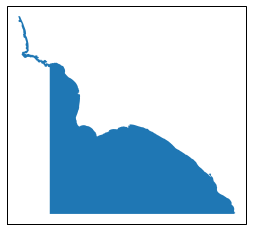

In [13]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ano_nuevo_shape.plot(ax=ax)

## Coastal Relief Model - Bathymetry
__Source: NCEI__<br>
__Website: https://www.ngdc.noaa.gov/mgg/coastal/crm.html__<br>
__Spatial Resolution: 3-arc seconds__<br>


For now:
Bathymetry data at the MPA level should be can be accessed through [NOAA NCEI Baythmetric Data Viewer](https://maps.ngdc.noaa.gov/viewers/bathymetry/?layers=dem#)


This could be updated from local DEMs or survey data if it deemed useful and the data is widely available

Steps:
1. Load the Bathymetry data into an xarray dataset
2. Extract elevation data below .5 meters
3. Smooth elevation to extract the coastline



In [14]:
bathy = xr.open_dataset('Data/MPA Bathy Subsets/ano_nuevo_SMR_bathy.nc')
y = bathy['lat'].values
x = bathy['lon'].values
xx,yy = np.meshgrid(x, y)
elv = bathy['Band1'].values
elv_smooth = ndimage.gaussian_filter(elv, sigma=2, order=0) # This is a smoothing function for the contours
elv[elv>.5] = np.nan # This removes replaces all data that is above 0.5 meters in elevation

In [15]:
# This is a function to make a custome color map for the bathymetry
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with n colors
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

# make negative contours, normally dashed by default, be solid
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [16]:
# Set the levels for the plotting bathymetery (ie detph contours)
blevels = np.concatenate((np.arange(-150,-40,20),np.arange(-40,1,5))) 
N = len(blevels)-1
bnorm = matplotlib.colors.BoundaryNorm(blevels, ncolors=N, clip=False)
cmap2 = custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue' ,maxcol='w')
cmap2.set_over('0.7') # light gray for anything above 0 meters

(-122.39, -122.23)

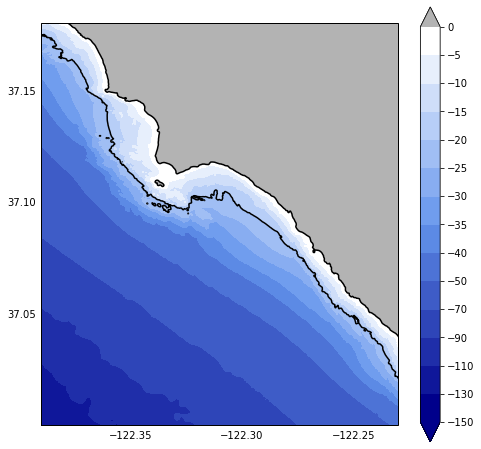

In [17]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = plt.axes(projection=ccrs.PlateCarree())
# MPA Shape File
ano_nuevo_shape.plot(ax=ax, alpha=.5,edgecolor='k',linewidth=3)
# Contour colors
pc = ax.contourf(xx,yy,elv_smooth, norm=bnorm, vmin=blevels.min(), vmax=blevels.max(), levels=blevels, cmap=cmap2, extend='both')
plt.colorbar(pc, ticks=blevels)
# Contour lines
ax.contour(xx,yy,elv_smooth,levels=[-1.], colors='black',zorder=20) # Highlight coastline (ie 1 meter isobath)
ax.contour(xx,yy,elv_smooth,levels=[-20], colors='black',zorder=20) # Highlight 20 meter isobath 

# THis is all formating stuff
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True) # This maps the gridlines, which are basically straight at this scale
# Turn off the lable ticks
gl.xlines = False
gl.ylines = False
# Turn off the lables on the top and right sides
gl.xlabels_top = False
gl.ylabels_right = False
# At what coordinates to place the labels
gl.xlocator = matplotlib.ticker.FixedLocator([-122.35,-122.3,-122.25])
gl.ylocator = matplotlib.ticker.FixedLocator([37.05,37.1,37.15])
# Change the scale of the map
ax.set_ylim(37,37.18)
ax.set_xlim(-122.39,-122.23)
# Save the figure (a dpi of 200-300 for hight resolution)
# plt.savefig('Figures/ano_nuevo_smr_map.png', dpi=300, bbox_inches='tight', pad_inches=.25)

## Merged Chlorophyll and NPP Data
__Source: Mati Kahru__<br>
__Website: https://www.wimsoft.com/CC4km.htm__<br>
__Spatial Resolution: 4km__<br>
__Temporal Resolution: Daily__<br>
__Time Span:1996-Present__


Data is scrapped and aggregated from wimsoft website using a python script (currently on Patrick's laptop)

Steps:
1. Load data into `xarray` dataset
2. Extract nearest cells
3. Plot mean from timeseries

In [19]:
# Load the data
merged_chl_ds = xr.open_mfdataset('Data/Remote Sensing Data/chl_merged_dataset/chl_merged_netcdf/*.nc')
dsr = merged_chl_ds.salem.roi(shape=ano_nuevo_shape, all_touched=True)
mean_merged = dsr.mean(dim=['time'])['chl']
mean_merged_timeseries = dsr.mean(dim=['lat','lon'])['chl']

In [20]:
# Find nearest cell
nearest_cell = merged_chl_ds.sel(lat=37.1, lon=-122.34, method='nearest')
x = nearest_cell['lon'].values
y = nearest_cell['lat'].values
print(x,y)
iy = np.where((merged_chl_ds['lat'].values - y )== 0)[0][0]
ix = np.where((merged_chl_ds['lon'].values - x )== 0)[0][0]
print('Cell index location:',ix,iy)

-122.35094730983303 37.08633028846154
Cell index location: 389 220


The idea here is to grab the surround cells based on the closest cell, which has an index of: `ix,iy`

In [21]:
dsr = merged_chl_ds.isel(lat=slice(iy-3,iy+4), lon=slice(ix-3,ix+4))
mean_merged = dsr.mean(dim=['time'])['chl']
mean_merged_timeseries = dsr.mean(dim=['lat','lon'])['chl']

__Plot percentage of available data days__

This is done by checking the number of times a single cell is finite or not (ie is it a real number of a NaN (not-a-number and not finite). This is done using the `np.isfinite` function, which returns a 3-D matrix of Booleans (time,lat,lon) 

The matrix of booleans are then summed along the time dimension (True = 1, False = 0) using `axis=0`, this is the time dimension. These values are divided by the total number of time samples to give a percentage.

In [22]:
fraction_available_data = np.sum(np.isfinite(dsr['chl']), axis=0)/dsr.time.size #Fracation of availible data
print(fraction_available_data.values) # Availability matrix

[[0.67376331 0.61853475 0.         0.         0.         0.
  0.        ]
 [0.73625548 0.74376957 0.69016907 0.         0.         0.
  0.        ]
 [0.76418284 0.75904822 0.70920476 0.         0.         0.
  0.        ]
 [0.76418284 0.75904822 0.70920476 0.62943018 0.         0.
  0.        ]
 [0.77307451 0.76518472 0.77457733 0.77808391 0.70206637 0.
  0.        ]
 [0.77207264 0.77658109 0.78121478 0.77169693 0.73638071 0.71559173
  0.        ]
 [0.78384471 0.78747652 0.77808391 0.79949906 0.81014402 0.81377583
  0.78071384]]


__This cell is only run for generating data for Dash prototype__

In [34]:
# df_chl = pd.DataFrame(dsr['chl'].mean(dim={'lat','lon'}).to_pandas())
# df_chl = df_chl.rename(columns={0:'chlorophyll'})
# df_chl = df_chl.resample('1M').mean()
# df_chl.to_csv('./Data/dash_data/ano_nuevo_monthly_chl.csv')

Text(0, 0.5, 'Chl-a')

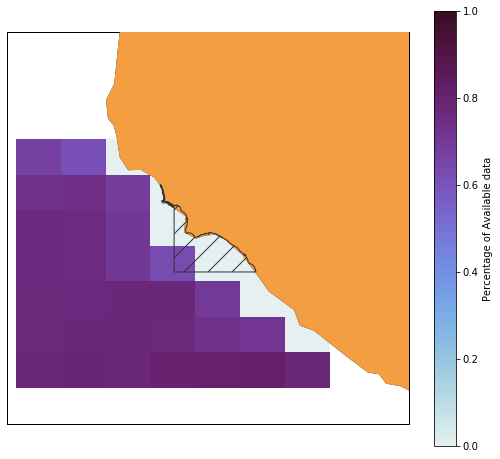

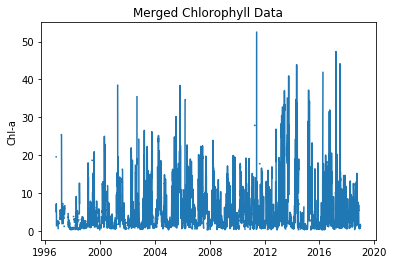

In [23]:
fig = plt.figure()
fig.set_size_inches(9,8)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('10m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='#f49e42'),zorder=10)
ano_nuevo_shape.plot(ax=ax,zorder=11,fc="None", hatch='/',ec='.2')

ax.set_xlim(ax.get_xlim()[0]-.15, ax.get_xlim()[1]+.15)
ax.set_ylim(ax.get_ylim()[0]-.15, ax.get_ylim()[1]+.15)

cmap2 = cmocean.cm.dense
fraction_available_data.plot.imshow(cmap=cmap2,vmin=0,vmax=1,cbar_kwargs={"label":'Percentage of Available data'})

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.plot(mean_merged_timeseries['time'], mean_merged_timeseries)
ax.set_title('Merged Chlorophyll Data')
ax.set_ylabel('Chl-a')

## Merged Net Primary Productivity (NPP) - Kahru
__Source: Mati Kahru__<br>
__Website: https://www.wimsoft.com/CC4km.htm__<br>
__Spatial Resolution: 4km__<br>
__Temporal Resolution: Daily__<br>
__Time Span:1996-Present__

In [84]:
merged_npp_ds = xr.open_mfdataset('Data/Remote Sensing Data/NPP_winsoft_dataset/npp_netcdf/*.nc')

In [87]:
# Find nearest cell
nearest_cell = merged_npp_ds.sel(lat=37.1, lon=-122.34, method='nearest')
x = nearest_cell['lon'].values
y = nearest_cell['lat'].values
print(x,y)
iy = np.where((merged_npp_ds['lat'].values - y )== 0)[0][0]
ix = np.where((merged_npp_ds['lon'].values - x )== 0)[0][0]
print('Cell index location:',ix,iy)

-122.35094730983303 37.08633028846154
Cell index location: 389 220


In [89]:
dsr = merged_npp_ds.isel(lat=slice(iy-3,iy+4), lon=slice(ix-3,ix+4))
dsr = dsr.where(dsr.npp >=9, np.nan)
mean_merged = dsr.mean(dim=['time'])['npp']
mean_merged_timeseries = dsr.max(dim=['lat','lon'])['npp']

__Calculate the percentage of available days__

In [90]:
fraction_available_data = np.sum(np.isfinite(dsr['npp']), axis=0)/dsr.time.size #Fracation of availible data
print(fraction_available_data.values) # Availability matrix

[[0.88560701 0.87521902 0.00262829 0.         0.         0.
  0.        ]
 [0.91789737 0.92140175 0.90387985 0.00275344 0.         0.
  0.        ]
 [0.92891114 0.93291615 0.91414268 0.00275344 0.00262829 0.
  0.        ]
 [0.92891114 0.93291615 0.91414268 0.90750939 0.00262829 0.00262829
  0.        ]
 [0.93579474 0.93679599 0.93153942 0.93717146 0.92790989 0.00237797
  0.        ]
 [0.94292866 0.93942428 0.94205257 0.94217772 0.93066333 0.92916145
  0.        ]
 [0.94292866 0.94155194 0.93842303 0.94418023 0.94430538 0.94192741
  0.9387985 ]]


Text(0, 0.5, 'NPP')

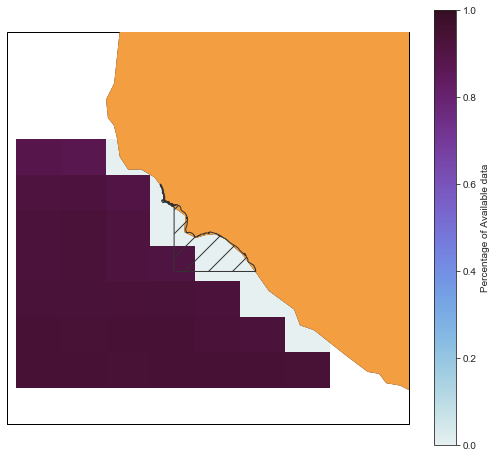

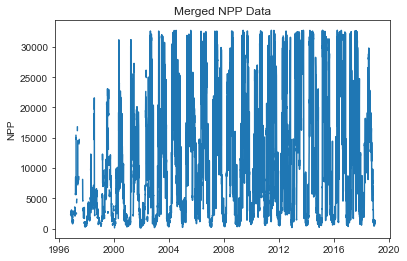

In [99]:
fig = plt.figure()
fig.set_size_inches(9,8)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('10m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='#f49e42'),zorder=10)
ano_nuevo_shape.plot(ax=ax,zorder=11,fc="None", hatch='/',ec='.2')
ax.set_xlim(ax.get_xlim()[0]-.15, ax.get_xlim()[1]+.15)
ax.set_ylim(ax.get_ylim()[0]-.15, ax.get_ylim()[1]+.15)

cmap2 = cmocean.cm.dense
fraction_available_data.plot.imshow(cmap=cmap2,vmin=0,vmax=1,cbar_kwargs={"label":'Percentage of Available data'})

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.plot(mean_merged_timeseries['time'], mean_merged_timeseries)
ax.set_title('Merged NPP Data')
ax.set_ylabel('NPP')

## Sea Surface Temperature (West Coast AVHRR)
__Source: NOAA Coastwatch__<br>
__Website: https://coastwatch.pfeg.noaa.gov/infog/AT_ssta_las.html__<br>
__Spatial Resolution: 0.0125 degree grid__<br>
__Accuracy: 0.7 degrees C__<br>
__Temporal Resolution: Composites: 1-day, 3-day, 8-day, Monthly__<br>
__Time Span:2006-Present__

Notes: For this dataset, we will utilize a software package called `Dask` to parallelize some of the temperature calculations. This works by performing these calculation on different threads on the computer (or on a cluster).

We can observe the performance of the Dask Client with the built in dashboard.

__Note (02/19/20): TDS is currently down for this dataset


In [4]:
from dask.distributed import Client

In [5]:
client = Client(n_workers=3, threads_per_worker=3)
client

Client Scheduler: tcp://127.0.0.1:60115 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 9 Memory: 17.18 GB


In [18]:
url = "http://thredds.cencoos.org/thredds/dodsC/ERDATSSTAMDAY.nc"
ds = xr.open_dataset(url,chunks={"time":4},) # This will make chunks in the time dimension 
ds = ds.assign_coords(longitude=-360+ds['longitude']) #flip the longitude from degrees to degrees E 
ds.longitude.attrs.update(ds.longitude.attrs)
ds = ds.sel(latitude=slice(37,37.18),longitude=slice(-122.42,-122.23))

Use Salem Region of Interest (MPA Shapefile) to grab data that touches

In [24]:
dsr = ds.salem.roi(shape=ano_nuevo_shape, all_touched=True)
dsr = dsr.load()

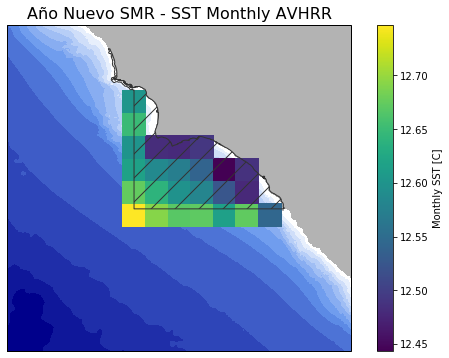

In [74]:
# Plot Mean SST
fig = plt.figure()
fig.set_size_inches(9,6)
ax = plt.axes(projection=ccrs.PlateCarree())
dsr.isel(altitude=0).mean(dim=['time'])['sst'].plot(zorder=25, ax=ax, cbar_kwargs={"label": 'Monthly SST [C]', "spacing": "proportional"})
# ax.contourf(x_sst, y_sst, sst,zorder=25)

ano_nuevo_shape.plot(ax=ax,zorder=26,fc="None", hatch='/',ec='.2')
pc = ax.contourf(xx,yy,elv_smooth, norm=bnorm, vmin=blevels.min(), vmax=blevels.max(), levels=blevels, cmap=cmap2, extend='both')

ax.set_ylim(37,37.18)
ax.set_xlim(-122.42,-122.23)
ax.set_title('Año Nuevo SMR - SST Monthly AVHRR', size=16)
# plt.savefig('Figures/ano_nuevo_map_SST_mean.png',dpi=300, bbox_inches='tight', pad_inches=.15)

__Basic Statistics: Linear Regression of Spatial Mean__

We are going to convert the spatial mean into a time series and calculate a linear regression. Converting the dataset into a pandas dataframe will make these manipulations easier.

In [80]:
mean_sst_timeseries = dsr.isel(altitude=0).mean(dim=['latitude','longitude'])['sst']
df = pd.DataFrame(mean_sst_timeseries.to_pandas())
df = df.reset_index()
df = df.rename(columns={0:'sst'})

,time,sst
0,2007-04-16 00:00:00,9.552340
1,2007-04-16 00:00:00,9.552340
2,2007-05-16 12:00:00,9.887281
3,2007-06-16 00:00:00,11.950029
4,2007-06-16 00:00:00,11.950029
...,...,...
204,2019-08-16 12:00:00,14.182492
205,2019-09-16 00:00:00,13.677076
206,2019-09-16 00:00:00,13.677076
207,2019-10-16 12:00:00,13.056849


Text(0.5, 1.0, 'Año Nuevo SMR - AVHRR SST')

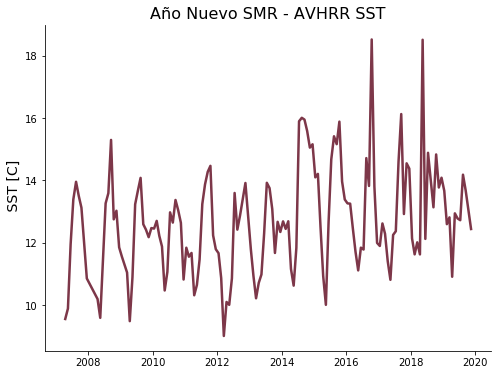

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.plot(df['time'],df['sst'],color="#7D3749",lw=2.5)
sns.despine()
ax.set_ylabel(' SST [C]', size=14)
ax.set_xlabel("")
ax.set_title('Año Nuevo SMR - AVHRR SST',size=16)

# plt.savefig('Figures/ano_nuevo_SST_timeseries.png',dpi=300, bbox_inches='tight', pad_inches=.15)

__Calculate the linear regression on the monthly data__ 

We will use the `scipy.stats` library to estimate estimate a linear regression

In [85]:
from scipy import stats

In [91]:
x = df.index
y = df['sst'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
y1 = x*slope + intercept

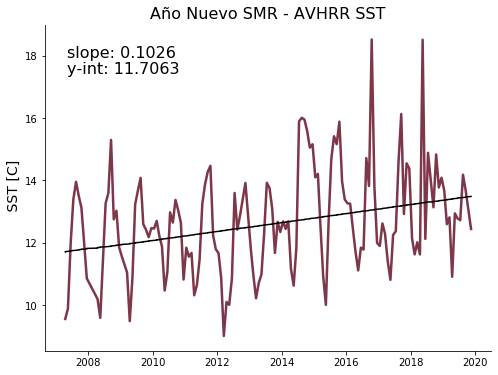

In [107]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.plot(df['time'],df['sst'],color="#7D3749",lw=2.5)
ax.plot(df['time'], y1, color="k",)
sns.despine()
ax.set_ylabel(' SST [C]', size=14)
ax.set_xlabel("")
ax.set_title('Año Nuevo SMR - AVHRR SST',size=16)
ax.text(.05,.9,"slope: "+str(round(slope*12,4)),transform=ax.transAxes,size=16)
ax.text(.05,.85,"y-int: "+str(round(intercept,4)),transform=ax.transAxes,size=16)
# plt.savefig('Figures/ano_nuevo_SST_timeseries_LR.png',dpi=300, bbox_inches='tight', pad_inches=.15)

## Kelp Forest - Landsat

## Kelp Coverage - Landset  (West Coast AVHRR)
__Source: UCSB LTER__<br>
__Data Source: https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-sbc&identifier=74&revision=newest__ <br>
__Protocol: https://sbclter.msi.ucsb.edu/external/Reef/Protocols/kelp_biomass_landsat/SBC_LTER_Landsat_Protocol_2017.pdf__<br>
__Spatial Resolution: 30 x 30 meter per pixel__<br>
__Temporal Resolution: Composites: Quarterly__<br>
__Time Span:1984?-Present__


In this dataset we are going to convert each observation into a Shapely Point object.

These data are not CF-compliant, so there is a bit of wrangling involved to get them into shape. The data are indexed by Station and Time, where a coordinate pair is associate with each Station. This makes using the region of interest approach a little tricky.

My solution is to use a Point-in-a-Polygon approach, converting each station into



In [143]:
from shapely.geometry import Point

In [144]:
# Data downloaded locally from EDI
fname = 'Data/knb-lter-sbc/LandsatKelpBiomass.nc'
ds = xr.open_dataset(fname)

In [150]:
df = pd.DataFrame(ds['lat'].to_pandas())
df = df.rename(columns={0:'lat'})
df['lon'] = ds['lon'].to_pandas()
df['coord_points'] = [Point(lon, lat) for lat, lon in zip(df['lat'].values, df['lon'].values)]
df['within_mpa'] = [p.within(ano_nuevo_shape['geometry'].values[0]) for p in df['coord_points'].values]
df = df[df['within_mpa']==True]
df = df.iloc[:-1]

In [151]:
stations = df.index.values
example_kelp = ds.isel(station=slice(stations[0],stations[-1]+1), time=123)
df['kelp_biomass'] = example_kelp['biomass'].values
df.head()

,lat,lon,coord_points,within_mpa,kelp_biomass
station,,,,,
309128,37.100514,-122.326520,POINT (-122.3265201 37.10051418),True,0.0
309129,37.100783,-122.326180,POINT (-122.3261801 37.10078267),True,0.0
309130,37.100785,-122.326518,POINT (-122.3265177 37.10078459),True,0.0
309131,37.101063,-122.327866,POINT (-122.3278657 37.10106266),True,0.0
309132,37.101065,-122.328203,POINT (-122.3282033 37.10106458),True,0.0


Text(0.5, 1, 'Año Nuevo SMR - Macrocystis p. Biomass, Oct-Dec 2014')

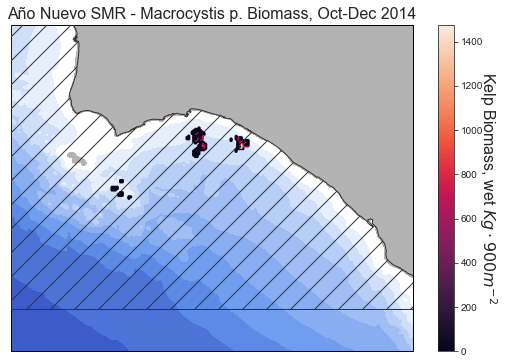

In [149]:
fig = plt.figure()
fig.set_size_inches(9,6)
ax = plt.axes(projection=ccrs.PlateCarree())
ano_nuevo_shape.plot(ax=ax,zorder=26,fc="None", hatch='/',ec='.2')

pc = ax.contourf(xx,yy,elv_smooth, norm=bnorm, vmin=blevels.min(), vmax=blevels.max(), levels=blevels, cmap=cmap2, extend='both')
ax.set_ylim(37.07,37.135)
ax.set_xlim(-122.35,-122.27)

cax = ax.scatter(df['lon'],df['lat'],c=df['kelp_biomass'],s=5,zorder=40)
cbar = plt.colorbar(cax,)
cbar.ax.get_yaxis().labelpad = 15


cbar.ax.set_ylabel('Kelp Biomass, wet $Kg \cdot 900 m^{-2}$', rotation=270,size=16)

ax.set_title('Año Nuevo SMR - Macrocystis p. Biomass, Oct-Dec 2014', size=16)
# plt.savefig('Figures/ano_nuevo_map_kelp_biomass.png',dpi=300, bbox_inches='tight', pad_inches=.15)

Interpreting time from is a little tricky here. The data are sampled into quarterly.

We need to map the center month of that quarter (and year) to a datetime object

In [152]:
kelp = ds.isel(station=slice(stations[0],stations[-1]))
df = pd.DataFrame(kelp['biomass'].sum(dim='station').to_pandas())
df = df.rename(columns={0:'kelp_biomass'})
df['year'] = ds['year'].to_pandas()
df['quarter'] = ds['quarter'].to_pandas() # "1=Jan-Mar,2=Apr-June,3=Jul-Sep,4=Oct-Dec
month = ["02","05","08","11"]
quarter = [1,2,3,4]
quarter_map = pd.DataFrame(data={'month':month},index=quarter)
df['month'] = df['quarter'].map(quarter_map['month'])
df['date'] = pd.to_datetime(df['year'].astype(str)+"/"+df['month'].astype(str),format='%Y/%m')

Text(0.5, 1.0, 'Año Nuevo SMR - Total Macrocystis p. Biomass')

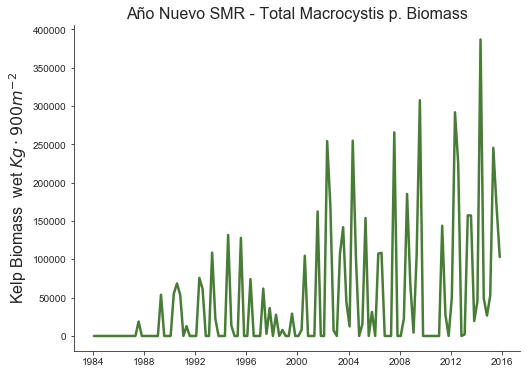

In [153]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.plot(df['date'],df['kelp_biomass'],color="#497D37",lw=2.5)
# ax.plot(df['time'], y1, color="k",)
sns.despine()
ax.set_ylabel('Kelp Biomass  wet $Kg \cdot 900 m^{-2}$', size=16)
ax.set_xlabel("")
ax.set_title('Año Nuevo SMR - Total Macrocystis p. Biomass',size=16)
# ax.text(.05,.9,"slope: "+str(round(slope*12,4)),transform=ax.transAxes,size=16)
# ax.text(.05,.85,"y-int: "+str(round(intercept,4)),transform=ax.transAxes,size=16)
# plt.savefig('Figures/ano_nuevo_Kelp_timeseries.png',dpi=300, bbox_inches='tight', pad_inches=.15)

Other Datasets PISCO Temperature Mooring (See the other notebook for this):

__Temperature Mooring Data Location__

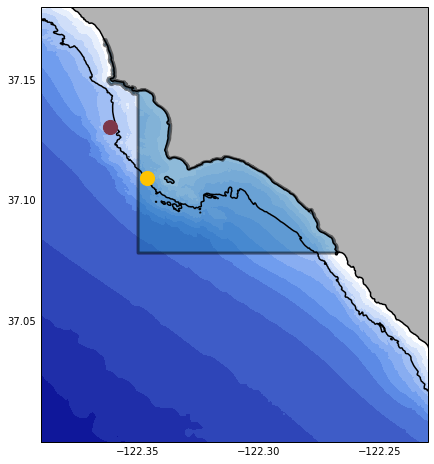

In [278]:
coord = ( -122.361253,37.130150)

fig = plt.figure()
fig.set_size_inches(8,8)
ax = plt.axes(projection=ccrs.PlateCarree())
pc = ax.contourf(xx,yy,elv_smooth, norm=bnorm, vmin=blevels.min(), vmax=blevels.max(), levels=blevels, cmap=cmap2, extend='both')
ano_nuevo_shape.plot(ax=ax, alpha=.5,edgecolor='k',linewidth=3)
cl = ax.contour(xx,yy,elv_smooth,levels=[-20], colors='black',zorder=20)
# ax.coastlines(resolution='10m')
cl = ax.contour(xx,yy,elv_smooth,levels=[-1.], colors='black',zorder=20)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlines = False
gl.ylines = False

gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.FixedLocator([-122.35,-122.3,-122.25])
gl.ylocator = matplotlib.ticker.FixedLocator([37.05,37.1,37.15])

ax.set_ylim(37,37.18)
ax.set_xlim(-122.39,-122.23)

ax.scatter(coord[0],coord[1],s=200,c='#7D3749',zorder=30)
ax.scatter(-122.346, 37.109,s=200,c='#FFC300',zorder=30)

# plt.savefig('Figures/ano_nuevo_smr_mooring_map.png', dpi=200,bbox_inches='tight',pad_inches=.25)